In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf

# Veri dizinleri
train_dir = "/kaggle/input/clahe-esrgan-split-fundus-dataset/train"
test_dir = "/kaggle/input/clahe-esrgan-split-fundus-dataset/test"
img_size = (224, 224)
batch_size = 32

# Veri setlerini yükle
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=False
)

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Veri artırma (Data Augmentation) katmanları
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])

# Veri setine artırma uygula
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# MobileNetV2 için ön işleme fonksiyonu
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Veri setine normalizasyon uygula
train_dataset = train_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)
test_dataset = test_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)

# Veri setlerini performans için optimize et
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 17524 files belonging to 8 classes.
Found 4384 files belonging to 8 classes.


In [2]:
from tensorflow.keras.applications import MobileNetV2

# MobileNetV2 modelini yükle
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Model mimarisi
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_dataset.element_spec[1].shape[1], activation='softmax')
])

# Modeli derle
model.compile(optimizer=Adam(learning_rate=2e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('mobilenetv2_model.keras', save_best_only=True, monitor='val_accuracy')
epochs = 50

# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 237s 416ms/step - accuracy: 0.6771 - loss: 0.9615 - val_accuracy: 0.8540 - val_loss: 0.4196
Epoch 2/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 213s 389ms/step - accuracy: 0.8391 - loss: 0.4705 - val_accuracy: 0.8638 - val_loss: 0.3783
Epoch 3/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 217s 395ms/step - accuracy: 0.8456 - loss: 0.4354 - val_accuracy: 0.8615 - val_loss: 0.3708
Epoch 4/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 210s 383ms/step - accuracy: 0.8513 - loss: 0.4178 - val_accuracy: 0.8659 - val_loss: 0.3691
Epoch 5/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 215s 392ms/step - accuracy: 0.8540 - loss: 0.4036 - val_accuracy: 0.8695 - val_loss: 0.3626
Epoch 6/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 215s 391ms/step - accuracy: 0.8562 - loss: 0.3926 - val_accuracy: 0.8707 - val_loss: 0.3635
Epoch 7/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 214s 391ms/step - accuracy: 0.8593 - loss: 0.3861 - val_accuracy: 0.8725 - val_loss: 0.3478
Epoch 8/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 214s 390ms/step - accuracy: 0.8561 -

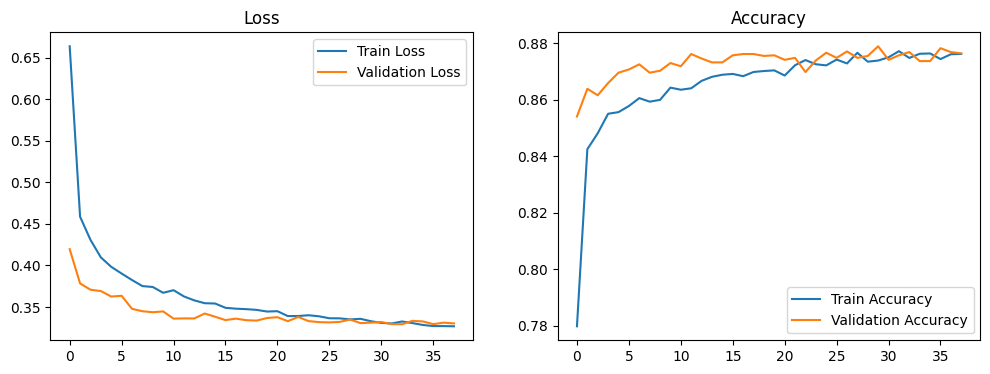

In [4]:
# Eğitim ve doğrulama kaybını ve doğruluğunu çiz
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [5]:
# Test veri seti üzerinde modeli değerlendir
test_loss, test_accuracy = model.evaluate(test_dataset)

# Sonuçları yazdır
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8637 - loss: 0.3406
Test Loss: 0.3292
Test Accuracy: 0.8768


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

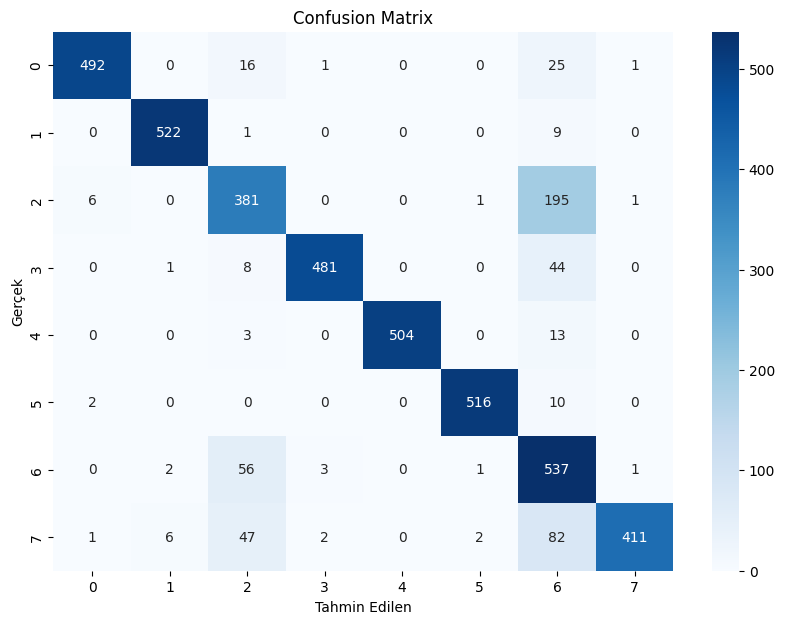

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cmp)

# Confusion matrix'i görselleştir
plt.figure(figsize=(10, 7))
sns.heatmap(cmp, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

Sınıf İsimleri: ['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']
Seçilen Sınıf: G
Seçilen Görsel: /kaggle/input/clahe-esrgan-split-fundus-dataset/test/G/aug_0_8940.jpg


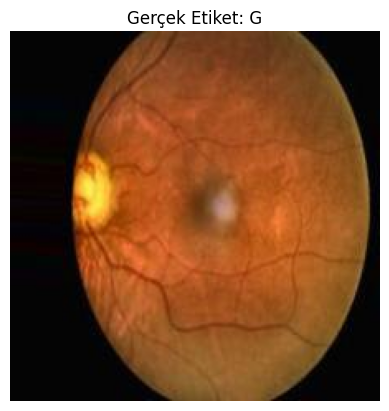

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Gerçek Etiket: G
Tahmin Edilen Etiket: O
Tahmin Olasılıkları: [4.7579244e-05 1.9660865e-01 4.9955817e-04 4.8725535e-05 3.5274343e-08
 1.6860860e-04 2.2325404e-02 7.8030145e-01]


In [7]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Test dizinindeki klasörleri (sınıfları) al
class_names = sorted(os.listdir(test_dir))  # Klasör adlarını al
print("Sınıf İsimleri:", class_names)

# Rastgele bir sınıf seç
random_class = random.choice(class_names)
print("Seçilen Sınıf:", random_class)

# Seçilen sınıftan rastgele bir görsel seç
random_image_path = os.path.join(test_dir, random_class, random.choice(os.listdir(os.path.join(test_dir, random_class))))
print("Seçilen Görsel:", random_image_path)

# Görseli yükle ve ön işleme yap
img = tf.keras.preprocessing.image.load_img(random_image_path, target_size=img_size)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Modelin beklediği şekilde (1, 224, 224, 3)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)  # Normalizasyon

# Görseli göster
plt.imshow(img)
plt.title(f"Gerçek Etiket: {random_class}")
plt.axis('off')
plt.show()

# Tahmin yap
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]  # En yüksek olasılığa sahip sınıf

# Sonucu yazdır
print(f"Gerçek Etiket: {random_class}")
print(f"Tahmin Edilen Etiket: {predicted_class}")
print(f"Tahmin Olasılıkları: {predictions[0]}")

Attention

Epoch 1/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 231s 406ms/step - accuracy: 0.6914 - loss: 0.9102 - val_accuracy: 0.8602 - val_loss: 0.4009
Epoch 2/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 210s 383ms/step - accuracy: 0.8465 - loss: 0.4440 - val_accuracy: 0.8656 - val_loss: 0.3826
Epoch 3/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 213s 388ms/step - accuracy: 0.8532 - loss: 0.4122 - val_accuracy: 0.8700 - val_loss: 0.3628
Epoch 4/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 211s 385ms/step - accuracy: 0.8599 - loss: 0.3918 - val_accuracy: 0.8672 - val_loss: 0.3525
Epoch 5/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 212s 387ms/step - accuracy: 0.8590 - loss: 0.3826 - val_accuracy: 0.8711 - val_loss: 0.3514
Epoch 6/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 215s 393ms/step - accuracy: 0.8675 - loss: 0.3625 - val_accuracy: 0.8766 - val_loss: 0.3385
Epoch 7/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 216s 394ms/step - accuracy: 0.8662 - loss: 0.3601 - val_accuracy: 0.8759 - val_loss: 0.3436
Epoch 8/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 215s 392ms/step - accuracy: 0.8654 -

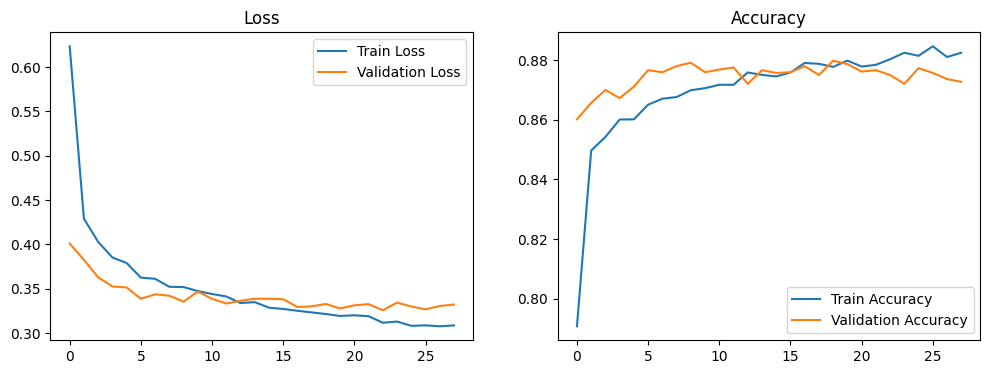

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Dense, Multiply, Conv2D, Activation, Reshape, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Channel Attention Modülü
class ChannelAttention(Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio
        self.gap = GlobalAveragePooling2D()
        self.dense1 = None
        self.dense2 = None

    def build(self, input_shape):
        channels = input_shape[-1]
        self.dense1 = Dense(units=int(channels / self.ratio), activation='relu')
        self.dense2 = Dense(units=channels, activation='sigmoid')
        super(ChannelAttention, self).build(input_shape)

    def call(self, inputs):
        gap = self.gap(inputs)
        fc1 = self.dense1(gap)
        fc2 = self.dense2(fc1)
        fc2 = Reshape((1, 1, fc2.shape[1]))(fc2)
        return Multiply()([inputs, fc2])

# Spatial Attention Modülü
class SpatialAttention(Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.conv = Conv2D(filters=1, kernel_size=self.kernel_size, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        attention = self.conv(concat)
        return Multiply()([inputs, attention])

# MobileNetV2 modelini yükle
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Model mimarisi
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # Tüm modeli çağır

# Attention modüllerini belirli katmanlara ekle
x = ChannelAttention()(x)
x = SpatialAttention()(x)

# Global Average Pooling ve diğer katmanlar
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_dataset.element_spec[1].shape[1], activation='softmax')(x)

# Modeli oluştur
model = tf.keras.Model(inputs, outputs)

# Modeli derle
model.compile(optimizer=Adam(learning_rate=2e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('mobilenetv2_attention_model.keras', save_best_only=True, monitor='val_accuracy')

# Modeli eğit
epochs = 50
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

# Eğitim ve doğrulama kaybını ve doğruluğunu çiz
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

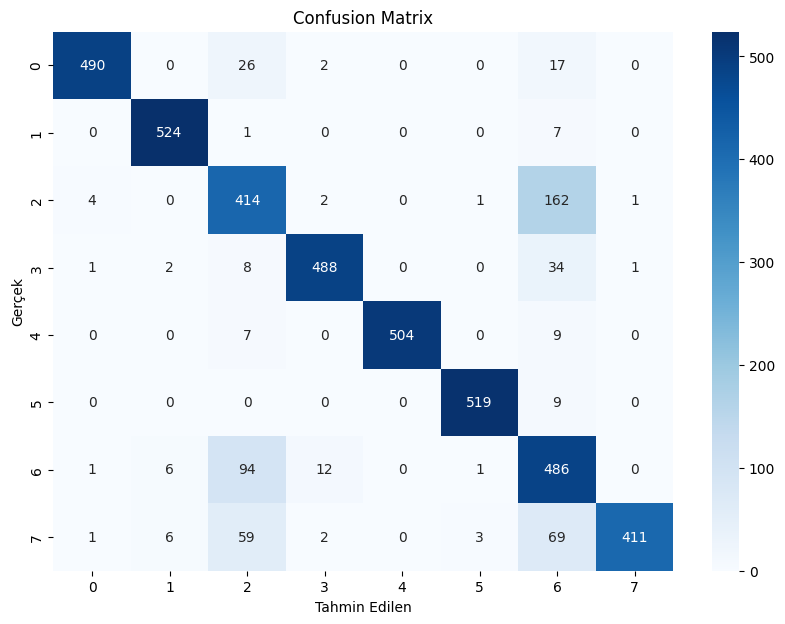

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cmp)

# Confusion matrix'i görselleştir
plt.figure(figsize=(10, 7))
sns.heatmap(cmp, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()